In [1]:
import os
import pybedtools
import pandas as pd
import numpy as np
import glob
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import random
from Bio import SeqIO
from Bio.Seq import Seq
import pysam

In [2]:
transcript_df = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/RPS2/annotated_transcript_editsC_lm_dec2023.txt', sep='\t')

In [3]:
low_translation_transcript = np.array_split(transcript_df.sort_values('RPS2_mean'), 4)[0].transcript_id.tolist()
high_translation_transcript = np.array_split(transcript_df.sort_values('RPS2_mean'), 4)[3].transcript_id.tolist()

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [4]:
gtf_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/gencode.v19.annotation.gtf'  # Replace with your GTF file path
fasta_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/hg19.fa'

In [5]:
from Bio import SeqIO

def extract_sequences(fasta_file, df):
    # Load the genome sequence
    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))

    # Extract sequences
    sequences = {}
    for _, row in df.iterrows():
        seqname = row[0]
        start = row[3]
        end = row[4]
        sequence = genome[seqname].seq[start-1:end]  # Adjust for 0-based indexing
        sequences[row['key']] = str(sequence)

    return sequences

In [6]:
def assign_utr(x):
    strand = x[6]
    utr_start = x[3]
    utr_end = x[4]
    if strand =='+':
        if utr_end < gtf_CDS_start[x['transcript_id']]:
            return '5UTR'
        elif utr_start > gtf_CDS_end[x['transcript_id']]:
            return '3UTR'

    if strand =='-':
        if utr_start > gtf_CDS_end[x['transcript_id']]:
            return '5UTR'
        elif utr_end <  gtf_CDS_start[x['transcript_id']]:
            return '3UTR'

In [7]:
# load GTF and get isoform characteristics
gencode_transcripts = pd.read_csv(gtf_file, sep='\t', comment='#', header=None)
gencode_transcripts['transcript_id'] = gencode_transcripts[8].str.extract('transcript_id "([^"]+)"')
gencode_transcripts['gene_id'] = gencode_transcripts[8].str.extract('gene_id "([^"]+)"')
gencode_transcripts['gene_name'] = gencode_transcripts[8].str.extract('gene_name "([^"]+)"')

### get CDS features

In [9]:
CDS = gencode_transcripts[gencode_transcripts[2]=='CDS']

In [10]:
gtf_CDS_start = dict(zip(CDS['transcript_id'], CDS[3]))
gtf_CDS_end = dict(zip(CDS['transcript_id'], CDS[4]))

In [13]:
CDS['length'] = CDS[4] - CDS[3]
CDS['key'] = CDS.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)

/tmp/ipykernel_1441204/4172467024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CDS['length'] = CDS[4] - CDS[3]
/tmp/ipykernel_1441204/4172467024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CDS['key'] = CDS.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)


In [14]:
CDS_seq_dict = extract_sequences(fasta_file, CDS)

### Get UTR features

In [15]:
UTR = gencode_transcripts[gencode_transcripts[2]=='UTR']
UTR[2] = UTR.apply(assign_utr, axis=1)

/tmp/ipykernel_1441204/3028768742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UTR[2] = UTR.apply(assign_utr, axis=1)


In [16]:
five_UTR = UTR[UTR[2]=='5UTR']
three_UTR = UTR[UTR[2]=='3UTR']
five_UTR['key'] = five_UTR.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)
three_UTR['key'] = three_UTR.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)


/tmp/ipykernel_1441204/3718035876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_UTR['key'] = five_UTR.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)
/tmp/ipykernel_1441204/3718035876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_UTR['key'] = three_UTR.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)


In [17]:
five_UTR['length'] = five_UTR[4] - five_UTR[3]
three_UTR['length'] = three_UTR[4] - three_UTR[3]

/tmp/ipykernel_1441204/3584739827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_UTR['length'] = five_UTR[4] - five_UTR[3]
/tmp/ipykernel_1441204/3584739827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_UTR['length'] = three_UTR[4] - three_UTR[3]


In [18]:
five_UTR_seq_dict = extract_sequences(fasta_file, five_UTR)
three_UTR_seq_dict = extract_sequences(fasta_file, three_UTR)

### Add sequence and get sequence features

In [19]:
CDS['sequence'] = CDS.key.map(CDS_seq_dict)

/tmp/ipykernel_1441204/3567514383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CDS['sequence'] = CDS.key.map(CDS_seq_dict)


In [20]:
five_UTR['sequence'] = five_UTR.key.map(five_UTR_seq_dict)

/tmp/ipykernel_1441204/3291725023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_UTR['sequence'] = five_UTR.key.map(five_UTR_seq_dict)


In [21]:
three_UTR['sequence'] = three_UTR.key.map(three_UTR_seq_dict)

/tmp/ipykernel_1441204/3127873794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_UTR['sequence'] = three_UTR.key.map(three_UTR_seq_dict)


In [22]:
def calc_gc(x):
    seq = x['sequence'].upper()
    if len(x['sequence']) > 0:
        return (seq.count('C') + seq.count('G'))/((seq.count('C') + seq.count('G') + seq.count('A') + seq.count('T')))
    else:
        return None

In [23]:
CDS['GC_content'] = CDS.apply(calc_gc, axis=1)
five_UTR['GC_content'] = five_UTR.apply(calc_gc, axis=1)
three_UTR['GC_content'] = three_UTR.apply(calc_gc, axis=1)

/tmp/ipykernel_1441204/2717125845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CDS['GC_content'] = CDS.apply(calc_gc, axis=1)
/tmp/ipykernel_1441204/2717125845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_UTR['GC_content'] = five_UTR.apply(calc_gc, axis=1)
/tmp/ipykernel_1441204/2717125845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [24]:
from scipy import stats

In [29]:
def plot_low_high_boxplot(low, high, scale, feature):
    '''plot characteristics in boxplot format for low and high categories'''
    sns.set(rc={'figure.figsize':(5,5)})
    sns.set_style('white')
    low_toplot=low.copy()
    high_toplot=high.copy()
    low_toplot['category']='low'
    high_toplot['category']='high'
    sns.boxplot(data=pd.concat([low_toplot, high_toplot]), x='category', y=feature,hue='category',  palette=['#028090','#F38A2E'])
    if scale==True:
        plt.xscale('log')
    plt.text(0.5, np.max(high_toplot[feature]), f"{stats.ranksums(low[feature], high[feature])[1]:.3f}")
    plt.legend(['low', 'high'])
    plt.show()
    print(stats.ranksums(low[feature], high[feature]))

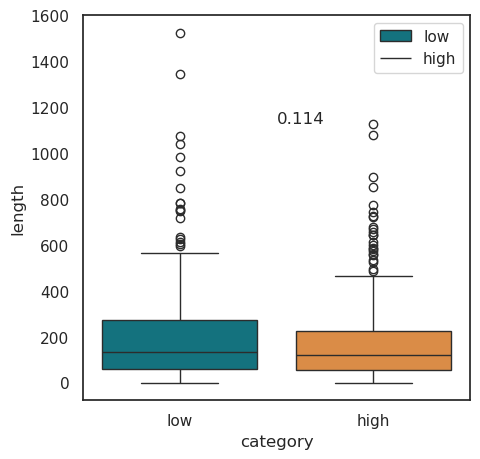

RanksumsResult(statistic=1.5788097538650085, pvalue=0.11437970066707796)


In [30]:
plot_low_high_boxplot(five_UTR[five_UTR['transcript_id'].isin(low_translation_transcript)], five_UTR[five_UTR['transcript_id'].isin(high_translation_transcript)], False, 'length')

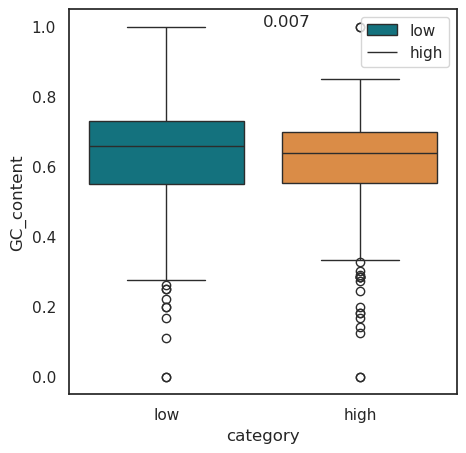

RanksumsResult(statistic=2.7201359378560186, pvalue=0.006525508400918482)


In [31]:
plot_low_high_boxplot(five_UTR[five_UTR['transcript_id'].isin(low_translation_transcript)], five_UTR[five_UTR['transcript_id'].isin(high_translation_transcript)], False, 'GC_content')

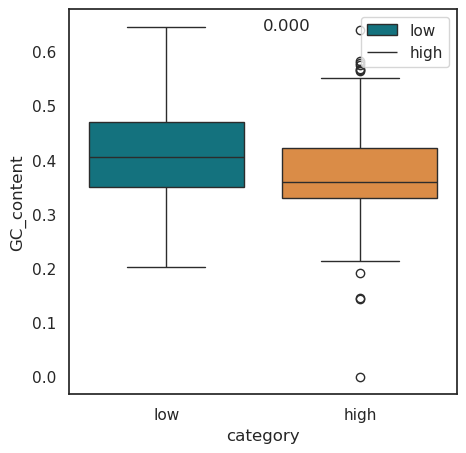

RanksumsResult(statistic=5.787695108339616, pvalue=7.135878074279573e-09)


In [32]:
plot_low_high_boxplot(three_UTR[three_UTR['transcript_id'].isin(low_translation_transcript)], three_UTR[three_UTR['transcript_id'].isin(high_translation_transcript)], False, 'GC_content')

### RBP motif analysis

In [34]:
motif_dir="/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/eCLIP_benchmarks/selex_linear"

In [36]:
# get RBP motifs
nuc_dict={0:'A', 1:'C', 2:'G', 3:'T'}
RBP_motifs={}
for d in glob.glob(os.path.join(motif_dir, "*")):
    tmp = pd.read_csv(d, index_col=0)
    consensus=[]
    for row, index in tmp.iterrows():
        nucleotide_probabilities=tmp.loc[row, :].values.tolist()
        max_value = max(nucleotide_probabilities)
        for i in [index for index, item in enumerate(nucleotide_probabilities) if item == max_value][:1]:
            consensus.append(nuc_dict[i])
    RBP_motifs[d.split('/')[-1].strip('.motif.csv')]=(''.join(consensus))
    

In [38]:
RBP_motifs['RBFOX2']='GCATG'
RBP_motifs['EIF4A']='GAAG'

In [40]:
def get_all_possible_motif_seqs(df):
    '''generate background'''
    all_possible = dict.fromkeys(list(RBP_motifs.keys()), 0)
    for key in RBP_motifs:
        count = 0
        for index, row in df.iterrows():
            query_seq = row['sequence']
            m = RBP_motifs[key]
            for i in range(0,len(query_seq)-len(m)+1):
                count +=1
        all_possible[key] = count
    return all_possible  

In [41]:
high_3p_background = get_all_possible_motif_seqs(three_UTR[three_UTR['transcript_id'].isin(high_translation_transcript)])

In [42]:
low_3p_background = get_all_possible_motif_seqs(three_UTR[three_UTR['transcript_id'].isin(low_translation_transcript)])

In [47]:
def count_motif_ocurrence(df):
    '''look for exact matches for each motif'''
    motif_count = {} # stores the number of times a motif appears in a sequence
    motif_present = {} # stores binary info, whether an isoform contains the motif or not
    for index, row in df.iterrows():
        motif_count[row['transcript_id']] = dict.fromkeys(list(RBP_motifs.keys()), 0)
        motif_present[row['transcript_id']] = dict.fromkeys(list(RBP_motifs.keys()), 0)
        for key in RBP_motifs:
            query_seq = row['sequence']
            m = RBP_motifs[key]
            for i in range(0,len(query_seq)-len(m)+1):
                if query_seq[i: i+len(m)] == m:
                    motif_count[row['transcript_id']][key] +=1
            if motif_count[row['transcript_id']][key] >=1:
                motif_present[row['transcript_id']][key] = 1
    return motif_count, motif_present

In [48]:
high_3P_motif_count, high_3P_motif_present = count_motif_ocurrence(three_UTR[three_UTR['transcript_id'].isin(high_translation_transcript)])

In [49]:
low_3P_motif_count, low_3P_motif_present = count_motif_ocurrence(three_UTR[three_UTR['transcript_id'].isin(low_translation_transcript)])

In [56]:
high_3p_present_df = pd.DataFrame.from_dict(high_3P_motif_present).T # convert dictionary to dataframe

In [57]:
high_3p_count_df = pd.DataFrame.from_dict(high_3P_motif_count).T # convert dictionary to dataframe

In [58]:
low_3p_present_df = pd.DataFrame.from_dict(low_3P_motif_present).T # convert dictionary to dataframe

In [59]:
low_3p_count_df = pd.DataFrame.from_dict(low_3P_motif_count).T # convert dictionary to dataframe

In [60]:
from scipy.stats import chi2_contingency, fisher_exact

In [62]:
## Chi-squared test of RBP motif presence
# a: Number of times an isoform has the motif from Group A
# b: Number of times an isoform does not have the motif from Group A
# c: Number of times an isoform has the motif from Group B
# d: Number of times an isoform does not have the motif from Group B
# N: Total observations
from scipy.stats import chi2_contingency, fisher_exact
chi2_results =[]
for rbp in RBP_motifs.keys():
    if 1 in low_3p_present_df[rbp].tolist():
        a, b = low_3p_present_df[rbp].value_counts()[1],low_3p_present_df[rbp].value_counts()[0]
        #print(a, b)
    else:
        a, b = 0,low_3p_present_df[rbp].value_counts()[0]
    
    if 1 in high_3p_present_df[rbp].tolist():     
        c, d = high_3p_present_df[rbp].value_counts()[1],high_3p_present_df[rbp].value_counts()[0]
        #print(c,d)
    else:
        c, d = 0, high_3p_present_df[rbp].value_counts()[0]
    # Chi-squared Test
    if a!= 0 or c != 0 :
        chi2, p_chi2, dof, expected = chi2_contingency([[a, b], [c, d]])
        print(rbp, [[a, b], [c, d]])
        N = np.sum(np.array([[a, b],[c, d]]))
        phi = np.sqrt(chi2 / N)

        chi2_results.append([rbp, phi, p_chi2])
        #print(rbp, "Chi-squared test p-value:", p_chi2)

ZFP36 [[14, 286], [9, 292]]
CELF3 [[1, 299], [0, 301]]
KHDRBS1 [[44, 256], [30, 271]]
MEX3D [[8, 292], [6, 295]]
ESRP1 [[1, 299], [0, 301]]
ZC3H8 [[69, 231], [38, 263]]
CSDA [[23, 277], [6, 295]]
CELF1 [[3, 297], [1, 300]]
RBM24 [[6, 294], [1, 300]]
TARDBP [[2, 298], [0, 301]]
YBX2 [[4, 296], [1, 300]]
RBM14 [[5, 295], [0, 301]]
SART3 [[1, 299], [0, 301]]
ELAVL4 [[8, 292], [8, 293]]
SNRPA [[9, 291], [6, 295]]
HNRPLL [[0, 300], [1, 300]]
HNRNPA3 [[1, 299], [0, 301]]
PCBP1 [[1, 299], [0, 301]]
RBPMS2 [[155, 145], [79, 222]]
IGF2BP1 [[8, 292], [5, 296]]
ZCRB1 [[3, 297], [2, 299]]
NOVA2 [[21, 279], [9, 292]]
HNRNPC [[2, 298], [0, 301]]
RBM46 [[35, 265], [15, 286]]
MEX3B [[1, 299], [0, 301]]
KHDRBS2 [[3, 297], [4, 297]]
ELAVL1 [[4, 296], [1, 300]]
HNRNPCL1 [[3, 297], [0, 301]]
PUM1 [[0, 300], [1, 300]]
DAZAP1 [[1, 299], [0, 301]]
CELF4 [[3, 297], [2, 299]]
RBPMS [[12, 288], [2, 299]]
ELAVL3 [[71, 229], [57, 244]]
DAZL [[10, 290], [6, 295]]
RBFOX2 [[212, 88], [154, 147]]
POLYA [[247, 53], [2

In [63]:
chi2_results_df = pd.DataFrame(chi2_results)

In [64]:
chi2_results_df.head()

,0,1,2
0,ZFP36,0.035024,0.390546
1,CELF3,0.000068,0.998671
2,KHDRBS1,0.066453,0.103287
3,MEX3D,0.011288,0.781988
4,ESRP1,0.000068,0.998671


In [65]:
chi2_results_df[chi2_results_df[0].isin(['RBFOX2', 'EIF4A'])]

,0,1,2
34,RBFOX2,0.196434,0.000001
37,EIF4A,0.186266,0.000005


In [66]:
chi2_results_df[3] = -np.log10(chi2_results_df[2]) # calculate the -log10(p-value)

In [69]:
# subset of RBPs we are interested in 
interest_RBPs = ['EIF4A', 'CELF1', 'CELF3', 'CELF4', 'ELAVL1', 'ELAVL3', 'HNRNPC', 'RBFOX2']

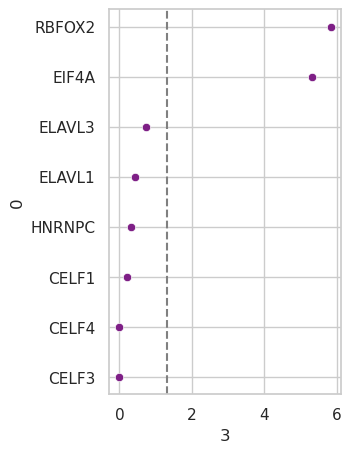

In [70]:
sns.set(rc={'figure.figsize':(3,5)})
sns.set_style('whitegrid')
sns.scatterplot(data=chi2_results_df[(~chi2_results_df[0].isin(['IRE', 'POLYA'])) & (chi2_results_df[0].isin(interest_RBPs))].sort_values(3, ascending=False), y=0, x=3, color='#7E1F86')#, size=1)
plt.axvline(-np.log10(0.05), linestyle='dashed', color='grey')

(<Figure size 300x300 with 3 Axes>,
 {('Low', 'RBFOX2 Present'): (0.0,
   0.0,
   0.4966846300941218,
   0.7043189368770764),
  ('Low', 'RBFOX2 Absent'): (0.0,
   0.7076411960132889,
   0.4966846300941218,
   0.29235880398671094),
  ('High', 'RBFOX2 Present'): (0.5016597544722312,
   0.0,
   0.49834024552776884,
   0.5099281464884493),
  ('High', 'RBFOX2 Absent'): (0.5016597544722312,
   0.513250405624662,
   0.49834024552776884,
   0.48674959437533794)})

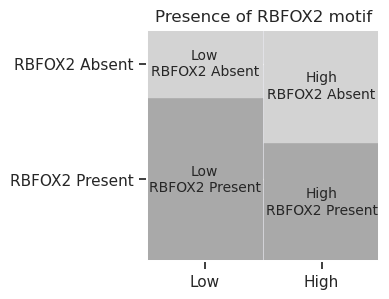

In [74]:
# Contingency table for RBFOX2
from statsmodels.graphics.mosaicplot import mosaic
sns.set(rc={'figure.figsize':(3,3)})
mosaic({('Low', 'RBFOX2 Present'): low_3p_present_df['RBFOX2'].sum(),
             ('Low', 'RBFOX2 Absent'): low_3p_present_df['RBFOX2'].value_counts().loc[0,],
             ('High', 'RBFOX2 Present'): high_3p_present_df['RBFOX2'].sum(),
             ('High', 'RBFOX2 Absent'): high_3p_present_df['RBFOX2'].value_counts().loc[0,]}, 
       labelizer=None, 
       title='Presence of RBFOX2 motif',properties=lambda key: {'color': 'darkgrey' if 'RBFOX2 Present' in key else 'lightgrey',})

(<Figure size 300x300 with 3 Axes>,
 {('Low', 'EIF4A Present'): (0.0, 0.0, 0.4966846300941218, 0.9667774086378736),
  ('Low', 'EIF4A Absent'): (0.0,
   0.9700996677740863,
   0.4966846300941218,
   0.029900332225913647),
  ('High', 'EIF4A Present'): (0.5016597544722312,
   0.0,
   0.49834024552776884,
   0.8609176499155637),
  ('High', 'EIF4A Absent'): (0.5016597544722312,
   0.8642399090517764,
   0.49834024552776884,
   0.13576009094822353)})

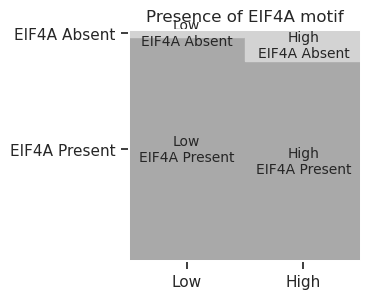

In [75]:
# Contingency table for EIF4A
from statsmodels.graphics.mosaicplot import mosaic
sns.set(rc={'figure.figsize':(3,3)})
mosaic({('Low', 'EIF4A Present'): low_3p_present_df['EIF4A'].sum(),
             ('Low', 'EIF4A Absent'): low_3p_present_df['EIF4A'].value_counts().loc[0,],
             ('High', 'EIF4A Present'): high_3p_present_df['EIF4A'].sum(),
             ('High', 'EIF4A Absent'): high_3p_present_df['EIF4A'].value_counts().loc[0,]}, 
       labelizer=None, 
       title='Presence of EIF4A motif',properties=lambda key: {'color': 'darkgrey' if 'EIF4A Present' in key else 'lightgrey',})

### 5' UTR uORF Analysis 

1) uORF downloaded from uORFdb: https://www.bioinformatics.uni-muenster.de/tools/uorfdb/download/index.hbi?
2) selected for hg38 and ATG starts only
3) liftOver to hg19

```liftOver 5p_coords_uORF.bed ~/projects/genomes/hg19/liftOver_files/hg38ToHg19.over.chain.gz 5p_coords_uORF.hg19.bed 5p_coords_uORF.hg19.unmapped```

In [76]:
low_5p_UTRs = five_UTR[five_UTR['transcript_id'].isin(low_translation_transcript)][[0,3,4,'key',5,6]]
high_5p_UTRs = five_UTR[five_UTR['transcript_id'].isin(high_translation_transcript)][[0,3,4,'key',5,6]]

In [77]:
low_5p_UTRs.columns = [0,1,2,3,4,5]
high_5p_UTRs.columns = [0,1,2,3,4,5]

In [78]:
#low_5p_UTRs.sort_values(by=[0,1,2]).to_csv('5p_coords_low.bed', sep='\t', header=None, index=False)

In [79]:
#high_5p_UTRs.sort_values(by=[0,1,2]).to_csv('5p_coords_high.bed', sep='\t', header=None, index=False)

overlap with 5' UTRs of low and high translation (bedtools intersect)

```bedtools intersect -a 5p_coords_uORF.hg19.bed -b 5p_coords_high.bed -wb > 5p_coords_high_uORF_overlap.txt```

```bedtools intersect -a 5p_coords_uORF.hg19.bed -b 5p_coords_low.bed -wb > 5p_coords_low_uORF_overlap.txt```

In [83]:
# load in overlap files
high_uorf_overlap = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/RPS2/5p_coords_high_uORF_overlap.txt', sep='\t', header=None)

In [84]:
# load in overlap files
low_uorf_overlap = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/RPS2/5p_coords_low_uORF_overlap.txt', sep='\t', header=None)

In [85]:
high_uorf_overlap['transcript_id'] = high_uorf_overlap.apply(lambda x: x[9].split(':')[0], axis=1)

In [86]:
low_uorf_overlap['transcript_id'] = low_uorf_overlap.apply(lambda x: x[9].split(':')[0], axis=1)

In [88]:
a_uorf = len(set(low_uorf_overlap['transcript_id']))
b_uorf = len(set(low_translation_transcript)) - len(set(low_uorf_overlap['transcript_id']))
c_uorf = len(set(high_uorf_overlap['transcript_id']))
d_uorf = len(set(high_translation_transcript)) - len(set(high_uorf_overlap['transcript_id']))

chi2_uorf , p_chi2_uorf , dof_uorf , expected_uorf  = chi2_contingency([[a_uorf, b_uorf], [c_uorf, d_uorf]])

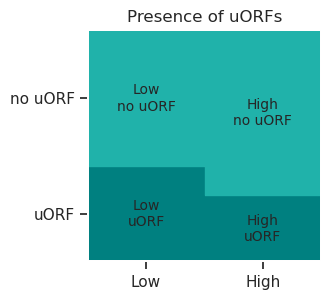

In [91]:
# Chi-squared for uORF presence
from statsmodels.graphics.mosaicplot import mosaic

# Example NumPy array
data = np.array([[a_uorf, b_uorf], [c_uorf, d_uorf]])

# Convert the array to a format suitable for the mosaic function
data_dict = {('Low', 'uORF'): data[0, 0],
             ('Low', 'no uORF'): data[0, 1],
             ('High', 'uORF'): data[1, 0],
             ('High', 'no uORF'): data[1, 1]}
props = lambda key: {'color': 'teal' if 'uORF' in key else 'lightseagreen',}

# Create the mosaic plot
sns.set(rc={'figure.figsize':(3,3)})

mosaic(data_dict, labelizer=None, title='Presence of uORFs',properties=props)
plt.show()

In [92]:
low_3p_UTRs = three_UTR[three_UTR['transcript_id'].isin(low_translation_transcript)][[0,3,4,'key',5,6]]
high_3p_UTRs = three_UTR[three_UTR['transcript_id'].isin(high_translation_transcript)][[0,3,4,'key',5,6]]

In [93]:
low_3p_UTRs.columns = [0,1,2,3,4,5]
high_3p_UTRs.columns = [0,1,2,3,4,5]

In [94]:
#low_3p_UTRs.sort_values(by=[0,1,2]).to_csv('3p_coords_low.bed', sep='\t', header=None, index=False)
#high_3p_UTRs.sort_values(by=[0,1,2]).to_csv('3p_coords_high.bed', sep='\t', header=None, index=False)

overlap with predicted miRNA binding sites using bedtools and re-load file

In [97]:
high_mirna_overlap = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/RPS2/3p_coords_high_mirna_overlap.txt', sep='\t', header=None)

In [98]:
low_mirna_overlap = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/RPS2/3p_coords_low_mirna_overlap.txt', sep='\t', header=None)

In [99]:
low_mirna_overlap['transcript_id'] = low_mirna_overlap.apply(lambda x: x[8].split(':')[0], axis=1)

In [100]:
high_mirna_overlap['transcript_id'] = high_mirna_overlap.apply(lambda x: x[8].split(':')[0], axis=1)

In [101]:
a_mirna = len(set(low_mirna_overlap['transcript_id']))
b_mirna = len(set(low_translation_transcript)) - len(set(low_mirna_overlap['transcript_id']))
c_mirna = len(set(high_uorf_overlap['transcript_id']))
d_mirna = len(set(high_translation_transcript)) - len(set(high_mirna_overlap['transcript_id']))

chi2_mirna , p_chi2_mirna , dof_mirna , expected_mirna  = chi2_contingency([[a_mirna, b_mirna], [c_mirna, d_mirna]])

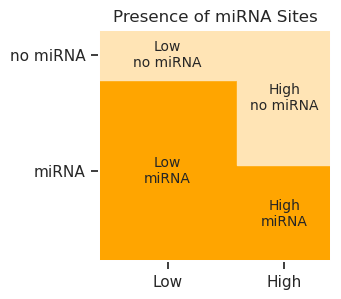

In [102]:
# Chi-squared test for predicted miRNA binding
from statsmodels.graphics.mosaicplot import mosaic

# Example NumPy array
data = np.array([[a_mirna, b_mirna], [c_mirna, d_mirna]])

# Convert the array to a format suitable for the mosaic function
data_dict = {('Low', 'miRNA'): data[0, 0],
             ('Low', 'no miRNA'): data[0, 1],
             ('High', 'miRNA'): data[1, 0],
             ('High', 'no miRNA'): data[1, 1]}
props = lambda key: {'color': 'orange' if 'miRNA' in key else 'moccasin',}

# Create the mosaic plot
sns.set(rc={'figure.figsize':(3,3)})

mosaic(data_dict, labelizer=None, title='Presence of miRNA Sites',properties=props)
plt.show()